In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import random
import h5py
import os
from tqdm import tqdm
from scipy import stats
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.stats import norm
from timm import create_model
import gc

def scale_data(data):
     return (data-np.min(data))/(np.max(data)-np.min(data))
    
df_test = pd.read_csv('../data/sample_submission.csv')
df_test['id'] = df_test['id'].apply(lambda x: Path("../data/test/")/f"{x}.hdf5")
def read_file(filename):
    file_id = Path(filename).stem
    img = np.empty((2, 360, 128), dtype=np.float32)
    with h5py.File(filename, "r") as f:
        g = f[file_id]

        for ch, s in enumerate(["H1", "L1"]):
            a = g[s]["SFTs"][:, :4096] * 1e22  # Fourier coefficient complex64
            p = a.real**2 + a.imag**2  # power
            p /= np.mean(p)  # normalize
            p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
            img[ch] = p
    return img


class DatasetVisualizer():
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df):
        self.df = df
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        filename=r.id
        file_id = Path(r.id).stem
        #img = np.empty((2, 360, 4096), dtype=np.float32)
        img = dict()
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64
                p = a.real**2 + a.imag**2  # power
                img[s] = [p.min(), p.max(), p.mean()]
        return img
    
def plot_sft(img):
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(img[0])
    axes[0].set_title('Detector=H1')
    axes[1].imshow(img[0])
    axes[1].set_title('Detector=L1')
    plt.tight_layout()
    plt.show()

In [2]:
split_voldf = Path("../data/SPLITS/V_19")
trn_df = pd.read_csv(split_voldf/'trn_df.csv')

In [3]:
#res = [ds[i] for i in tqdm(range(len(ds)))]

In [4]:
def normalize(x, pmin=3, pmax=99, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x


In [5]:
def read_file(filename):
    file_id = Path(filename).stem
    img = np.empty((2, 360, 4096), dtype=np.float32)
    with h5py.File(filename, "r") as f:
        g = f[file_id]

        for ch, s in enumerate(["H1", "L1"]):
            a = g[s]["SFTs"][:, :4096] * 1e22  # Fourier coefficient complex64
            p = a.real**2 + a.imag**2  # power
            img[ch] = p
    return img

class DataV0():
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.freq_tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        filename=r.id
        file_id = Path(r.id).stem
        img = np.empty((2, 360, 128), dtype=np.float32)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64
                p = a.real**2 + a.imag**2 # power
                p = np.sum(p.reshape(360, 128, 32), axis=2)
                img[ch] = p
        return img, y.astype('int')

In [6]:
dataset =  DataV0(df_test)

In [ ]:
trn_df.query('snr>200')

5373


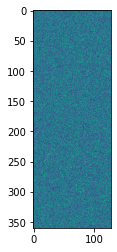

1929


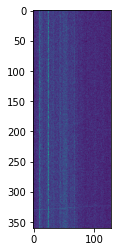

3067


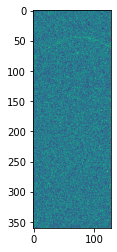

298


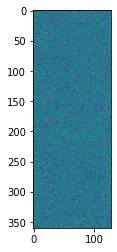

1452


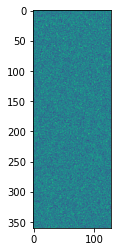

672


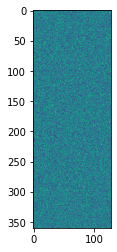

6893


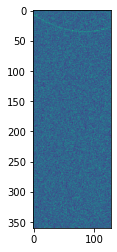

1500


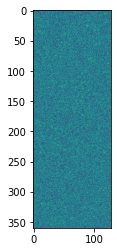

4556


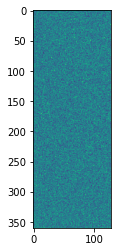

3693


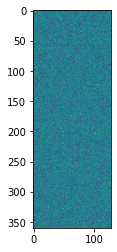

In [15]:
for i in range(10):
    k = np.random.randint(0, len(dataset))
    print(k)
    img, y = dataset[k]
    plt.imshow(img.mean(0))
    plt.pause(0.1)
    #plt.hist(img[0].flatten(),bins=100,alpha=0.1,color='b');
    #plt.hist(img[1].flatten(),bins=100,alpha=0.1,color='r');

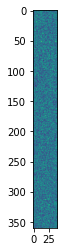

In [16]:
plt.imshow(img[0][:, :40])

In [40]:
def normalize(X):
    X = (X[..., None].view(X.real.dtype) ** 2).sum(-1)
    POS = int(X.size * 0.99903)
    EXP = norm.ppf((POS + 0.4) / (X.size + 0.215))
    scale = np.partition(X.flatten(), POS, -1)[POS]
    X /= scale / EXP.astype(scale.dtype) ** 2
    return X

from pdb import set_trace

In [41]:
def dataload(filepath):
    astime = np.full([2, 360, 5760], np.nan, dtype=np.float32)
    with h5py.File(filepath, "r") as f:
        fid, _ = os.path.splitext(os.path.split(filepath)[1])
        HT = (
            (np.asarray(f[fid]["H1"]["timestamps_GPS"]) / 1800).round().astype(np.int64)
        )
        LT = (
            (np.asarray(f[fid]["L1"]["timestamps_GPS"]) / 1800).round().astype(np.int64)
        )
        MIN = min(HT.min(), LT.min())
        HT -= MIN
        LT -= MIN
        H1 = normalize(np.asarray(f[fid]["H1"]["SFTs"], np.complex128))
        valid = HT < 5760
        astime[0][:, HT[valid]] = H1[:, valid]
        L1 = normalize(np.asarray(f[fid]["L1"]["SFTs"], np.complex128))
        valid = LT < 5760
        astime[1][:, LT[valid]] = L1[:, valid]
    gc.collect()
    return fid, astime, H1.mean(), L1.mean()

def preprocess(num, input, H1, L1):
    input = torch.from_numpy(input).to("cpu", non_blocking=True)
    rescale = torch.tensor([[H1, L1]]).to("cpu", non_blocking=True)
    tta = (
        torch.randn(
            [num, *input.shape, 2], device=input.device, dtype=torch.float32
        )
        .square_()
        .sum(-1)
    )
    tta *= rescale[..., None, None] / 2
    valid = ~torch.isnan(input); 
    tta[:, valid] = input[valid].float()
    return tta


In [42]:
class LargeKernel_debias(nn.Conv2d):
    def forward(self, input: torch.Tensor):
        finput = input.flatten(0, 1)[:, None]
        target = abs(self.weight)
        target = target / target.sum((-1, -2), True)
        joined_kernel = torch.cat([self.weight, target], 0)
        reals = target.new_zeros(
            [1, 1] + [s + p * 2 for p, s in zip(self.padding, input.shape[-2:])]
        )
        reals[
            [slice(None)] * 2 + [slice(p, -p) if p != 0 else slice(None) for p in self.padding]
        ].fill_(1)
        output, power = torch.nn.functional.conv2d(
            finput, joined_kernel, padding=self.padding
        ).chunk(2, 1)
        ratio = torch.div(*torch.nn.functional.conv2d(reals, joined_kernel).chunk(2, 1))
        output = output.sub(power.mul(ratio))
        return output.unflatten(0, input.shape[:2]).flatten(1, 2)

In [43]:
model = create_model(
    "tf_efficientnetv2_b0",
    in_chans=32,
    num_classes=2,
)
state_dict = torch.load('model_best.pth')
C, _, H, W = state_dict["conv_stem.2.weight"].shape

In [44]:
debias = LargeKernel_debias(in_channels = 1,
                            out_channels=C, 
                            kernel_size = [H, W], 
                            stride = 1, 
                            padding = [H//2, W//2],
                            dilation = 1, 
                            groups= 1,
                            bias = False).cuda()

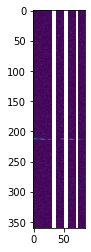

In [61]:
fid, img, H1_mean, L1_mean = dataload(trn_df['id'].loc[13])
plt.imshow(img[0][:, 15:100])


In [62]:
h_img = img[1]

In [66]:
h_img[~np.isnan(h_img)].reshape(360, -1)[:, :4096]

(360, 4487)

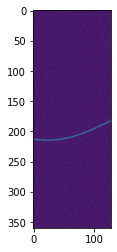

In [64]:
plt.imshow(h_img[~np.isnan(h_img)].reshape(360, -1)[:, :4096].reshape(360, 128, 32).mean(-1))


In [67]:
img_proc = preprocess(2, img, H1_mean, L1_mean)
img_proc.shape

torch.Size([2, 2, 360, 5760])

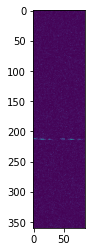

In [68]:
plt.imshow(img_proc[0][0][:, 15:100])


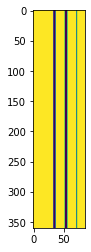

In [69]:
plt.imshow(img_proc[0][0][:, 15:100] == img_proc[1][0][:, 15:100])

In [71]:

out = debias(pool.clone().cuda())

NameError: name 'pool' is not defined

In [72]:
out.shape

NameError: name 'out' is not defined

In [73]:
out.max()

NameError: name 'out' is not defined

torch.Size([1, 2, 360, 384])


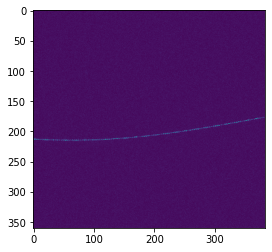

In [82]:
md = nn.Sequential(
        nn.Identity(),
        nn.AvgPool2d((1, 10), (1, 15), (0, 4), count_include_pad=False))
img_proc = preprocess(1, img, H1_mean, L1_mean)
pool = md(img_proc)
print(pool.shape)
plt.imshow(pool[0].mean(0))

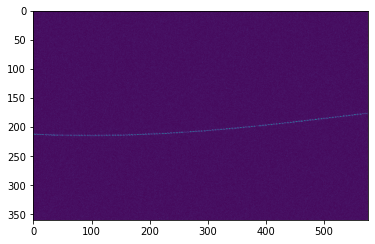

In [75]:
plt.imshow(pool[0].mean(0))